<h2>Imports</h2>

In [71]:
import requests
import numpy as np
import pandas as pd
import string
from datetime import datetime
from urllib.parse import unquote
from bs4 import BeautifulSoup
import concurrent.futures 
from concurrent.futures import ThreadPoolExecutor, ALL_COMPLETED
from collections import OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# API Endpoints for Wikipedia and Wikidata
WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"
WIKIPEDIA_API_ENDPOINT = "https://en.wikipedia.org/w/api.php"

# API Header to identify requestor for Wikipedia and Wikidata
HEADERS = {"User-Agent": "uni_coursework/2.0; nat.1.roongjirarat@kcl.ac.uk"}

# API Parameters for Wikipedia and Wikidata to get list of award winners, contennts of award winners' pages, and labels of award winners
PARAMS_QUERY_SEARCH = {
    "action":"query",
    "format":"json",
    "formatversion":"latest",
    "list":"search",
    "srsearch": "haswbstatement:P166=Q185667",
    "srlimit":"max"
}

PARAMS_GETCONTENT = {
    "action": "query",
    "format": "json",
    "titles": "",
    "prop": "extracts",
    "exlimit": "max"
}

PARAMS_WBGETENTITIES_LABELS = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "sites": "",
    "props": "labels",
    "languages": "en",
    "sitefilter": "enwiki",
    "utf8": 1,
    "ascii": 1,
    "formatversion": "latest"
}

PARAMS_WBGETENTITIES_SITES = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "sites": "",
    "props": "sitelinks/urls",
    "languages": "en",
    "sitefilter": "enwiki",
    "utf8": 1,
    "ascii": 1,
    "formatversion": "latest"
}

PARAMS_WBGETENTITIES_CLAIMS = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "props": "claims",
    "languages": "en",
    "sitefilter": "",
    "formatversion": "latest"
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nat_rng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nat_rng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nat_rng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/nat_rng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<h2> Activity 3 </h2>

<h3>3.1 Sub-activity: Loading and pre-processing of text data</h3>

<h4>Task 1</h4>

In [72]:
def get_turing_award_recipients():
    """
    Function to return a list of Turing Award winners from Wikidata.

    Returns:
        list: Entity IDs of Turing Award winners, e.g. ['Q12345', 'Q23456', ...]
        this list is used in Task 3 to iterate over the list of Turing Award winners and get their contents from Wikipedia
        and properties from Wikidata.
    """
    acm_award_entities = []
    search_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_QUERY_SEARCH)
    data = search_response.json()
    for result in data['query']['search']:
        acm_award_entities.append(result['title'])
    return acm_award_entities

print(get_turing_award_recipients())

['Q80', 'Q3572699', 'Q92894', 'Q17457', 'Q92612', 'Q92638', 'Q92743', 'Q92824', 'Q181529', 'Q204815', 'Q578036', 'Q92794', 'Q92739', 'Q49823', 'Q92602', 'Q3571662', 'Q92626', 'Q62870', 'Q92758', 'Q16080922', 'Q8556', 'Q92604', 'Q357965', 'Q11609', 'Q92609', 'Q439245', 'Q92670', 'Q92819', 'Q92851', 'Q92613', 'Q62874', 'Q92854', 'Q92628', 'Q7143512', 'Q62861', 'Q320624', 'Q45575', 'Q1107006', 'Q92614', 'Q62888', 'Q93080', 'Q476466', 'Q92820', 'Q92649', 'Q62898', 'Q92641', 'Q92742', 'Q93154', 'Q62843', 'Q92643', 'Q92823', 'Q462089', 'Q62866', 'Q92629', 'Q92618', 'Q92822', 'Q92596', 'Q92746', 'Q918650', 'Q62857', 'Q92619', 'Q92821', 'Q62877', 'Q92781', 'Q92782', 'Q92632', 'Q93161', 'Q92744', 'Q92606', 'Q9602', 'Q92625', 'Q62894', 'Q92644', 'Q92745', 'Q92828']


<h4>Task 2<h/4>

In [73]:
def get_wikipedia_content(entity_id):
    """
    Takes an enity ID or entity IDs (in the format Q111|Q111|...) of a Turing Award winner and returns the 
    content of the Wikipedia page of the Turing Award winner.

    Args:
        entity_id (str): The queery string of entity IDs, e.g. 'Q12345|Q23456|Q34567' or 'Q12345'

    Returns:
        str: Returns the HTML content of the Wikipedia page of the Turing Award winner/s as a string.
    """
    PARAMS_WBGETENTITIES_SITES["ids"] = entity_id
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_SITES)
    wbgetentities_data = wbgetentities_response.json()
    recipient_name = wbgetentities_data["entities"][entity_id]["sitelinks"]["enwiki"]["url"].split("https://en.wikipedia.org/wiki/")[1]
    try:
        PARAMS_GETCONTENT["titles"] = unquote(recipient_name)
        extracts_response = requests.get(WIKIPEDIA_API_ENDPOINT, headers=HEADERS, params=PARAMS_GETCONTENT)
        extracts_data = extracts_response.json()
        html_content = next(iter(extracts_data["query"]["pages"].values()))["extract"]
        content = BeautifulSoup(html_content, 'html.parser')
        if content.find("p", {"class":"mw-empty-elt"}):
            content.find("p", {"class":"mw-empty-elt"}).decompose()
        return str(content)
    except KeyError:
        return None

<h4>Task 3</h4>

In [74]:
def get_intro_data(entity_ids):
    """
    Takes a list of entity IDs of Turing Award winners and returns a dictionary of the intro of the Wikipedia page of the Turing Award winner/s.

    Args:
        entity_ids (list): List of entity IDs of Turing Award winners, e.g. ['Q12345', 'Q23456', ...] to retrieve the intro content of the Wikipedia
        page of the Turing Award winner/s.

    Returns:
        dict: Dictionary of the intro of the Wikipedia page of the Turing Award winner/s, with entity ID as the key and intro as the value,
        e.g. {'Q12345': 'This is the intro of Q12345', 'Q23456': 'This is the intro of Q23456', ...}
    """
    content_dict = dict()
    for entity_id in entity_ids:
        content_dict[entity_id] = get_wikipedia_content(entity_id).split("<h2>")[0]
    return content_dict

def get_wikidata_claims(entity_id):
    """
    Takes an entity ID of a Turing Award winner and returns the claims of the Wikidata page of the Turing Award winner.
    Claims are the properties of the Wikidata page of the Turing Award winner.
    
    Args:
        entity_id (str): The entity ID as a query string: 'Q12345'
        
    Returns:
        dict: Returns the claims of the Wikidata page of the Turing Award winner as a dictionary. The dictionary contains the 
        property ID as the key and property ID as the value.
    """
    PARAMS_WBGETENTITIES_CLAIMS["ids"] = entity_id
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_CLAIMS)
    wbgetentities_data = wbgetentities_response.json()
    claims = next(iter(wbgetentities_data["entities"].values()))["claims"]
    return claims

def get_wikidata_label(entity_query):
    """
    Takes an property ID or property IDs (in the format P111|P111|...) of a Turing Award winner and returns the label of the 
    Wikidata page corresponding to the property ID.
    
    Args:
        entity_query (str): The query string of property IDs, e.g. 'P12345|P23456|P34567' or 'P12345'
        
    Returns:
        dict: Returns the labels of the Wikidata page of the Turing Award winner/s as a dictionary. The dictionary contains the
        property ID as the key and the label as the value.
    """
    PARAMS_WBGETENTITIES_LABELS["ids"] = entity_query
    request_ids = set(entity_query.split("|"))
    request_labels = dict()
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_LABELS)
    wbgetentities_data = wbgetentities_response.json()
    for request_id in request_ids:
        labels = wbgetentities_data["entities"][request_id]["labels"]
        request_labels[request_id] = labels["en"]["value"]
    return request_labels

def check_key_exists(dict, key):
    """
    Verifies if a key exists in a Wikidata claims dictionary.

    Args:
        dict (dict): Input dictionary to verify if key exists.
        key (key): Key to check

    Returns:
        if Key exists: 
            list: List of all labels for a given property ID in the Wikidata claims dictionary.
        else    
            None: Return as None if key does not exist in dictionary.
    """
    if key in dict.keys():
        entity_ids = [dict[key][i]["mainsnak"]["datavalue"]["value"]["id"] for i in range(len(dict[key]))]
        return entity_ids
    else:
        return None

def call_wikidata_api(entity_id, content_dict):
    """
    Cal the wikidata API to retrieve the Wikidata labels for all properrties in the Turing Award winner Wikidata Page.
    Also retrieves the intro of the Wikipedia page of the Turing Award winner from a content dictionary.
    Args:
        entity_id (str): Entity ID of the Turing Award winner.
        content_dict (dict): Content dictionary of the intros from the Wikipedia pages of the Turing Award winners.

    Returns:
        name (str): Name of the Turing Award winner.
        intro (str): Intro of the Wikipedia page of the Turing Award winner as an HTML string.
        gender (str): Gender of the Turing Award winner.
        birth_date (DateTime): Birth date of the Turing Award winner as a datetime object.
        birth_city (str): Birth city of the Turing Award winner.
        employers (list): List of employers of the Turing Award winner. Ordered dictionary is used to remove duplicates and maintain ordering.
        educated_at (list): List of institutions the Turing Award winner was educated at. Ordered dictionary is used to remove duplicates and maintain ordering.
    """
    wiki_data_dict = {"gender": "P21", "birth_date": "P569", "birth_city": "P19", 
                  "birth_country": "P17", "employer": "P108", "educated_at": "P69"}
    claims = get_wikidata_claims(entity_id)
    request_entityids = {"name_id": [entity_id], "gender_id": check_key_exists(claims, wiki_data_dict["gender"]),
                       "birth_city_id" : check_key_exists(claims, wiki_data_dict["birth_city"]),
                       "employers_ids": check_key_exists(claims, wiki_data_dict["employer"]),
                       "educated_at_ids": check_key_exists(claims, wiki_data_dict["educated_at"])}
    
    
    entity_query = "|".join(["|".join(values) for values in request_entityids.values() if values != None])
    request_labels = get_wikidata_label(entity_query)
    
    try:
        name = request_labels[entity_id].split(" (")[0]
    except TypeError:
        name = None
    intro = content_dict[entity_id]
    try: 
        gender = request_labels[request_entityids["gender_id"][0]]
    except TypeError:
        gender = None
    try:
        birth_date = datetime.strptime(claims[wiki_data_dict["birth_date"]][0]["mainsnak"]["datavalue"]["value"]["time"], "+%Y-%m-%dT%XZ").strftime("%d %B %Y")
    except ValueError:
        birth_date = datetime.strptime(claims[wiki_data_dict["birth_date"]][0]["mainsnak"]["datavalue"]["value"]["time"], "+%Y-00-00T%XZ").strftime("%Y")
    except TypeError:
        birth_date = None
    try:
        birth_place = request_labels[request_entityids["birth_city_id"][0]] 
    except TypeError:
        birth_place = None
    if request_entityids["employers_ids"] != None:
        employer = list(OrderedDict.fromkeys([request_labels[key] for key in request_entityids["employers_ids"]]))
    else:
        employer = None
    if request_entityids["employers_ids"] != None:
        education = list(OrderedDict.fromkeys([request_labels[key] for key in request_entityids["educated_at_ids"]]))
    else:
        education = None
    return name, intro, gender, birth_date, birth_place, employer, education

def multi_thread_api_call(intro_dict, workers=10):
    """
    Multi Threaded API call to retrieve the Wikidata labels for all properties in the Turing Award winner Wikidata Page and 
    corresponding Wikipedia page. Defaults to 10 workers to make concourrent API calls. If a worker fails, it will retry the API call until
    all API calls are successful.
    
    Args:
        intro_dict (dict): Dicitionary of the intros from the Wikipedia pages of the Turing Award winners. Where the key is the entity ID and the value is the intro.
        workers (int, optional): Number of workers to make concurrnet API calls. Defaults to 10.

    Returns:
        list: The result of the API call for each Turing Award winner. Each item in the list is a tuple with the following structure:
        (name, intro, gender, birth_date, birth_place, employer, education)
    """
    results = []
    
    with ThreadPoolExecutor(max_workers=workers) as executor:
        api_calls = {executor.submit(call_wikidata_api, entity_id, intro_dict): entity_id for entity_id in intro_dict.keys()}
        while api_calls:
            retry_api_calls = {}
            done = concurrent.futures.wait(api_calls, return_when=ALL_COMPLETED)
            for api_call in done:
                for future in api_call:
                    if future.exception():
                        entity_id = api_calls[future]
                        retry_api_calls[executor.submit(call_wikidata_api, entity_id, intro_dict)] = entity_id
                    else:
                        results.append(future.result())
            api_calls = retry_api_calls   
    return results

def get_award_winners_data(results):
    """
    Takes an input list containing the results of the API call for each Turing Award winner and returns a dictionary with the following structure:
    {"name": [], "intro": [], "gender": [], "birth_date": [], "birth_place": [], "employer": [], "educated_at": []} 
    
    Args:
        results (tuple): Tuple with the following format (name, intro, gender, birth_date, birth_place, employer, education)
        to unpack and append to each list in the dictionary.

    Returns:
        dict: Dictionary of all award winners with the following structure, order is dependent on the API call execution order
        eeach value is stored in a list: 
        {"name": [], "intro": [], "gender": [], "birth_date": [], "birth_place": [], "employer": [], "educated_at": []} 
        
    See Also:
        def multi_thread_api_call(intro_dict, workers=10)
    """
    award_winners_dict = {"name": [], "intro": [], "gender": [], "birth_date": [], 
                      "birth_place": [], "employer": [], "educated_at": []} 
    for result in results:
        name, intro, gender, birth_date, birth_place, employer, education = result
        award_winners_dict["name"].append(name)
        award_winners_dict["intro"].append(intro)
        award_winners_dict["gender"].append(gender)
        award_winners_dict["birth_date"].append(birth_date)
        award_winners_dict["birth_place"].append(birth_place)
        award_winners_dict["employer"].append(employer)
        award_winners_dict["educated_at"].append(education)
    return award_winners_dict

In [75]:
# Get the list of Turing Award winners by Entity ID
acm_award_winners = get_turing_award_recipients()
# Get the intro from the Wikipedia page for each Turing Award winner as a dictionary
winner_intros = get_intro_data(acm_award_winners)
# List of tuples returned from the API call for each Turing Award winner (random order)
api_calls = multi_thread_api_call(winner_intros)
#Dictionary containing the data for each Turing Award winner
award_winners = get_award_winners_data(api_calls)

<h4>Task 4</h4>

In [76]:
# Print the names of the Turing Award winners in alphabetical order
for name in sorted(award_winners["name"]):
    print(name)

Adi Shamir
Alan Kay
Alan Perlis
Alfred Aho
Allen Newell
Amir Pnueli
Andrew Yao
Barbara Liskov
Bob Kahn
Butler Lampson
Charles Bachman
Charles P. Thacker
Dana Scott
David A. Patterson
Dennis M. Ritchie
Donald Knuth
Douglas Engelbart
E. Allen Emerson
Edgar F. Codd
Edmund M. Clarke
Edsger W. Dijkstra
Edward Feigenbaum
Edwin Catmull
Fernando J. Corbató
Frances E. Allen
Fred Brooks
Geoffrey Hinton
Herbert Simon
Iosif Sifakis
Ivan Sutherland
Jack Dongarra
James H. Wilkinson
Jeffrey David Ullman
Jim Gray
John Backus
John Cocke
John Edward Hopcroft
John L. Hennessy
John McCarthy
Judea Pearl
Juris Hartmanis
Ken Thompson
Kenneth E. Iverson
Kristen Nygaard
Leonard Adleman
Leslie Lamport
Leslie Valiant
Manuel Blum
Martin Edward Hellman
Marvin Minsky
Maurice Wilkes
Michael O. Rabin
Michael Stonebraker
Niklaus Wirth
Ole-Johan Dahl
Pat Hanrahan
Peter Naur
Raj Reddy
Richard E. Stearns
Richard Hamming
Richard M. Karp
Robert Tarjan
Robert W. Floyd
Robin Milner
Ron Rivest
Shafrira Goldwasser
Silvio Mical

<h4>Task 5</h4>

<h5> a) and b) </h5>

In [77]:
# create Panda DataFrame to store the data for each Turing Award winner intro text
award_winners_intro = pd.DataFrame(columns=["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])
# Add name of the Turing Award winner to the DataFrame
award_winners_intro["winner_name"] = award_winners["name"]

def get_intro_stats(intro):
    """
    Takes as input the intro text as an html string and returns the number of words, sentences, paragraphs and the 10 most common words in the intro.

    Args:
        intro (str): Intro text as an html string, get processed to remove html tags and punctuation.

    Returns:
        tuple: Tuple with the following structure (count_words, count_sentences, count_paragraphs, common_words). 
        Contains the number of words, sentences, paragraphs and the 10 most common words in the intro.
    """
    intro_html = BeautifulSoup(intro, "html.parser")
    intro_text = intro_html.get_text(" ").lower()
    count_words = sum([word.strip(string.punctuation).isalnum() for word in intro_text.split()])
    count_sentences = len(sent_tokenize(intro_text))
    count_paragraphs = len(intro_html.find_all("p"))
    word_filter = set(list(string.punctuation) + ["``", "''", "–"])
    word_freqdist= nltk.FreqDist([word for word in word_tokenize(intro_text) if word not in word_filter]).most_common(10)
    common_words = [word[0] for word in word_freqdist]
    return count_words, count_sentences, count_paragraphs, common_words

# Iterate and get the intro stats for each Turing Award winner, store the results in a dictionary, where the key are the intro stats and the values are lists
# for each Turing Award winner
intro_stats = {"word_count": [], "sentence_count": [], "paragraph_count": [], "common_words": []}
for intro in award_winners["intro"]:
    count_word, count_sentences, count_paragraphs, common_words = get_intro_stats(intro)
    intro_stats["word_count"].append(count_word)
    intro_stats["sentence_count"].append(count_sentences)
    intro_stats["paragraph_count"].append(count_paragraphs)
    intro_stats["common_words"].append(common_words)

# Add the intro stats to the DataFrame from the dictionary
award_winners_intro["count_words"] = intro_stats["word_count"]
award_winners_intro["count_sentences"] = intro_stats["sentence_count"]
award_winners_intro["count_paragraphs"] = intro_stats["paragraph_count"]
award_winners_intro["common_words"] = intro_stats["common_words"]

award_winners_intro.head()

,winner_name,count_words,count_sentences,count_paragraphs,common_words
0,John L. Hennessy,109,4,2,"[of, the, as, hennessy, computer, is, in, and,..."
1,Ivan Sutherland,150,6,1,"[the, of, in, computer, as, graphics, and, tha..."
2,Shafrira Goldwasser,68,1,1,"[of, the, and, at, is, computer, scientist, pr..."
3,Robert Tarjan,59,3,1,"[and, tarjan, is, the, of, computer, scientist..."
4,William Kahan,46,1,1,"[in, and, the, william, velvel, morton, kahan,..."


<h4>Task 5</h4>

<h5>c) and d)</h5>

In [78]:
def process_top10_common_words(intro):
    """
    Takes as input the intro text as an html string and returns the 10 most common words in the intro after removing stopwords and punctuation.

    Args:
        intro (str): Intro text as an html string, gets processed to remove html tags, punctuation and stop words.

    Returns:
        list: List with the 10 most common words in the intro after removing stopwords and punctuation.
    """
    intro_text = BeautifulSoup(intro, "html.parser").get_text(" ").lower()
    word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
    tokenized_intro = word_tokenize(intro_text)
    word_freqdist = nltk.FreqDist([word for word in tokenized_intro if word not in word_filter]).most_common(10)
    common_words = [word[0] for word in word_freqdist]
    return common_words

# Get the 10 most common words in the intro after removing stopwords and punctuation. Returned as a list of lists
common_words_after_preprocessing = [process_top10_common_words(intro) for intro in award_winners["intro"]]
# Add the 10 most common words in the intro after removing stopwords and punctuation to the DataFrame
award_winners_intro["common_words_after_preprocessing"] = common_words_after_preprocessing
# Get the first 10 rows of the DataFrame (order is dependent on the order the rows were called in the API)
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,John L. Hennessy,109,4,2,"[of, the, as, hennessy, computer, is, in, and,...","[hennessy, computer, inc., president, marc, jo..."
1,Ivan Sutherland,150,6,1,"[the, of, in, computer, as, graphics, and, tha...","[computer, graphics, sutherland, pioneer, earl..."
2,Shafrira Goldwasser,68,1,1,"[of, the, and, at, is, computer, scientist, pr...","[computer, scientist, professor, science, inst..."
3,Robert Tarjan,59,3,1,"[and, tarjan, is, the, of, computer, scientist...","[tarjan, computer, scientist, university, robe..."
4,William Kahan,46,1,1,"[in, and, the, william, velvel, morton, kahan,...","[william, velvel, morton, kahan, born, june, 5..."
5,Yann LeCun,155,7,3,"[the, of, and, is, he, computer, learning, wit...","[computer, learning, lecun, french, scientist,..."
6,Juris Hartmanis,44,1,1,"[the, july, computational, of, juris, hartmani...","[july, computational, juris, hartmanis, 5, 192..."
7,John Backus,150,6,3,"[the, and, of, programming, in, he, his, for, ...","[programming, fortran, award, backus, march, 1..."
8,Fred Brooks,95,3,3,"[the, of, in, computer, and, brooks, was, soft...","[computer, brooks, software, development, nati..."
9,Peter Naur,51,3,1,"[the, a, he, to, peter, naur, 25, october, 192...","[peter, naur, 25, october, 1928, 3, january, 2..."


<h3>3.2 Sub Activity:  Applying NLP operations on the corpus</h3>

<h4>3.2.1 Stemming</h4>

<h4>Task 3</h4>

<h5>a), b) and c)</h5>

In [79]:
def process_intro_words(intro):
    """
    Takes as input the intro text as an html string and returns the intro text after removing stopwords and punctuation.

    Args:
        intro (str): Intro text as an html string, gets processed to remove html tags, punctuation and stop words.

    Returns:
        list: List of all words in the intro text after removing stopwords and punctuation. Maintains capitalization of names, lower() method
        if applied implicitly in the stemmer methods and explicitly for thee lemmitization.
    """
    word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
    tokenized_intro = word_tokenize(intro)
    intro_words = [word for word in tokenized_intro if word.lower() not in word_filter]
    return intro_words

def count_unique_words(intro):
    """
    Takes as input the intro text as a list of words and returns the number of unique words in the intro.

    Args:
        intro (list): Intro text as a list of words.

    Returns:
        int: Number of unique words in the intro.
    """
    unique_intro_words = [word.lower() for word in intro]
    return len(list(nltk.FreqDist(unique_intro_words)))

# Join all intro texts into one long string and process the words to get the number of unique words across all intro texts before stemming
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)
original_unique_words = count_unique_words(intro_words)

print("Number of unique words before stemming with Porter Stemmer: {}".format(original_unique_words))

# Stem the intro words with Porter Stemmer and get the number of unique words across all intro texts after stemming
porter_stemmer = PorterStemmer()
intro_words_with_porterstemmer = [porter_stemmer.stem(word) for word in intro_words]

print("Number of unique words after stemming with Porter Stemmer: {}".format(len(list(nltk.FreqDist(intro_words_with_porterstemmer)))))

Number of unique words before stemming with Porter Stemmer: 1644
Number of unique words after stemming with Porter Stemmer: 1442


<h4>Task 4</h4>

<h5>a), b) and c)</h5>

In [80]:
# Join all intro texts into one long string and process the words to get the number of unique words across all intro texts before stemming
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)
original_unique_words = count_unique_words(intro_words)

print("Number of unique words before stemming with Porter Stemmer: {}".format(original_unique_words))

# Stem the intro words with Snowball Stemmer and get the number of unique words across all intro texts after stemming
snow_stemmer = SnowballStemmer(language='english')
intro_words_with_snowballstemmer = [snow_stemmer.stem(word) for word in intro_words]

print("Number of unique words after stemming with Snowball Stemmer: {}".format(len(list(nltk.FreqDist(intro_words_with_snowballstemmer)))))

Number of unique words before stemming with Porter Stemmer: 1644
Number of unique words after stemming with Snowball Stemmer: 1440


<h3>3.2.2 Lemmatization</h3>

<h3>Task 5</h3>

<h5>a), b) and c)</h5>

In [81]:
# Join all intro texts into one long string and process the words to get the number of unique words across all intro texts before stemming
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)
original_unique_words = count_unique_words(intro_words)

print("Number of unique words before stemming with Porter Stemmer: {}".format(original_unique_words))

# Lemmatize the intro words with Word Net Lemmatizer and get the number of unique words across all intro texts after lemmatization.
wordnet_lemmatizer = WordNetLemmatizer()
intro_words_wordnetlemmatizer = [wordnet_lemmatizer.lemmatize(word.lower()) for word in intro_words]

print("Number of unique words after lemmatization with Word Net Lemmatizer: {}".format(len(list(nltk.FreqDist(intro_words_wordnetlemmatizer)))))

Number of unique words before stemming with Porter Stemmer: 1644
Number of unique words after lemmatization with Word Net Lemmatizer: 1580


<h3>3.2.3 Finding synonyms and antonyms</h3>

<h4>Task 4</h4>

<h5>a), b), c) and d)</h5>

In [82]:
# Add synonyms and antonyms columns to the DataFrame
award_winners_intro = award_winners_intro.assign(synonyms = np.nan, antonyms = np.nan)
# Get all the common words from the preprocessed intro texts from the DataFrame
common_words_after_preprocessing = award_winners_intro["common_words_after_preprocessing"]

def get_synonyms(common_words):
    """
    Takes as input a list of common words and returns a list of synonyms for the common words.

    Args:
        common_words (list): List of common words.

    Returns:
        list: List of synonyms for the common words excluding the word itself. Ordered dictionary is used to remove duplicates and maintain ordering.
    """
    synonyms = [l.name() for word in common_words for syn in wordnet.synsets(word) for l in syn.lemmas() if l.name() != word]
    return list(OrderedDict.fromkeys(synonyms))

def get_antonyms(common_words):
    """
    Takes as input a list of common words and returns a list of antonyms for the common words.

    Args:
        common_words (list): List of common words.

    Returns:
        list: List of antonyms for the common words. Ordered dictionary is used to remove duplicates and maintain ordering.
    """
    antonyms = [l.antonyms()[0].name() for word in common_words for syn in wordnet.synsets(word) for l in syn.lemmas() if l.antonyms()]
    return list(OrderedDict.fromkeys(antonyms))

#iterate through the list of lists of common words and get the synonyms and antonyms for each word in the list, 
# outputting the results to the DataFrame's synonyms and antonyms columns
synonyms = []
antonyms = []
for common_words in common_words_after_preprocessing:
    synonyms_list, antonyms_list = get_synonyms(common_words), get_antonyms(common_words)
    synonyms.append(synonyms_list)
    antonyms.append(antonyms_list)

award_winners_intro["synonyms"] = synonyms
award_winners_intro["antonyms"] = antonyms

# Get the first 10 rows of the DataFrame (order is dependent on the order the rows were called in the API)
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,John L. Hennessy,109,4,2,"[of, the, as, hennessy, computer, is, in, and,...","[hennessy, computer, inc., president, marc, jo...","[computing_machine, computing_device, data_pro...",[unborn]
1,Ivan Sutherland,150,6,1,"[the, of, in, computer, as, graphics, and, tha...","[computer, graphics, sutherland, pioneer, earl...","[computing_machine, computing_device, data_pro...","[middle, late, ill, badly, disadvantageously, ..."
2,Shafrira Goldwasser,68,1,1,"[of, the, and, at, is, computer, scientist, pr...","[computer, scientist, professor, science, inst...","[computing_machine, computing_device, data_pro...",[]
3,Robert Tarjan,59,3,1,"[and, tarjan, is, the, of, computer, scientist...","[tarjan, computer, scientist, university, robe...","[computing_machine, computing_device, data_pro...",[unborn]
4,William Kahan,46,1,1,"[in, and, the, william, velvel, morton, kahan,...","[william, velvel, morton, kahan, born, june, 5...","[Morton, Jelly_Roll_Morton, Ferdinand_Joseph_L...",[unborn]
5,Yann LeCun,155,7,3,"[the, of, and, is, he, computer, learning, wit...","[computer, learning, lecun, french, scientist,...","[computing_machine, computing_device, data_pro...","[idle, malfunction]"
6,Juris Hartmanis,44,1,1,"[the, july, computational, of, juris, hartmani...","[july, computational, juris, hartmanis, 5, 192...","[July, five, V, cinque, quint, quintet, fiveso...",[]
7,John Backus,150,6,3,"[the, and, of, programming, in, he, his, for, ...","[programming, fortran, award, backus, march, 1...","[scheduling, programing, computer_programming,...",[misused]
8,Fred Brooks,95,3,3,"[the, of, in, computer, and, brooks, was, soft...","[computer, brooks, software, development, nati...","[computing_machine, computing_device, data_pro...","[hardware, devolution, nondevelopment, interna..."
9,Peter Naur,51,3,1,"[the, a, he, to, peter, naur, 25, october, 192...","[peter, naur, 25, october, 1928, 3, january, 2...","[Peter, Simon_Peter, Saint_Peter, St._Peter, S...",[]


<h4>3.2.4 Bigrams and trigrams</h4>

<h4>Task 7</h4>

In [83]:
# Join all intro texts into one long string and process the words by removing stop words and punctuation. 
# Output the result to a list of words from all intro texts.
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)

<h4>Task 8</h4>

In [84]:
def get_bigrams_frequency(words_list):
    """
    Takes as input a list of words and returns a dictionary of bigrams as keys and their frequencies as values. Capitalization is maintained 
    to differentiate between words that are used in different contexts. (E.g. "Computer Science" and "computer science", to diffeerentiate
    between a department/entity of Computer Science and the field of study)

    Args:
        words_list (list): List of words in the order they appear in the text. (Input text is tokenized and preprocessed in Task 7)

    Returns:
        dict: Dictionary of bigrams as keys and their frequencies as values.
    """
    bigrams = nltk.bigrams(words_list)
    bigrams_freqdist = nltk.FreqDist(bigrams)
    return dict(bigrams_freqdist)

<h4>Task 9</h4>

In [85]:
# Save the dictionary of bigrams and their frequencies to a variable called award_winners_bigrams
winners_bigrams = get_bigrams_frequency(intro_words)

<h4>Task 10</h4>

In [86]:

# Sort the dictionary of bigrams and their frequencies by their frequencies in descending order and print the top 15 bigrams.
# Exact order is dependent on the order the rows were called in the API. In other words, the order of the bigrams with the same frequency is not guaranteed.
# To get the exact same order, print more than 15 to verify bigrams with the same frequencies.
# Print the top 15 bigrams
def get_top_bigrams(bigrams_dict, top_n):
    """
    Takes as input a dictionary of bigrams and their frequencies and returns a dictionary of the top n bigrams and their frequencies.

    Args:
        bigrams_dict (dict): Dictionary of bigrams as keys and their frequencies as values.
        top_n (int): Number of top bigrams to return.

    Returns:
        dict: Dictionary of top n bigrams as keys and their frequencies as values.
    """
    top_n_bigrams = dict(sorted(bigrams_dict.items(), key=lambda bigram_dict: bigram_dict[1], reverse=True)[:top_n])
    return top_n_bigrams

top15_bigrams = get_top_bigrams(winners_bigrams, 15)

print("Top 15 bigrams: {}".format(", ".join([str(bigram) for bigram in top15_bigrams.keys()])))

Top 15 bigrams: ('computer', 'scientist'), ('Turing', 'Award'), ('American', 'computer'), ('computer', 'science'), ('Computer', 'Science'), ('programming', 'language'), ('best', 'known'), ('National', 'Academy'), ('programming', 'languages'), ('artificial', 'intelligence'), ('received', 'Turing'), ('Academy', 'Engineering'), ('Carnegie', 'Mellon'), ('Stanford', 'University'), ('Professor', 'Computer')


<h3>3.3 Sub-section: Visualisation</h3>

<h4>3.3.1 Barplots</h4>

<h4>Task 11</h4>

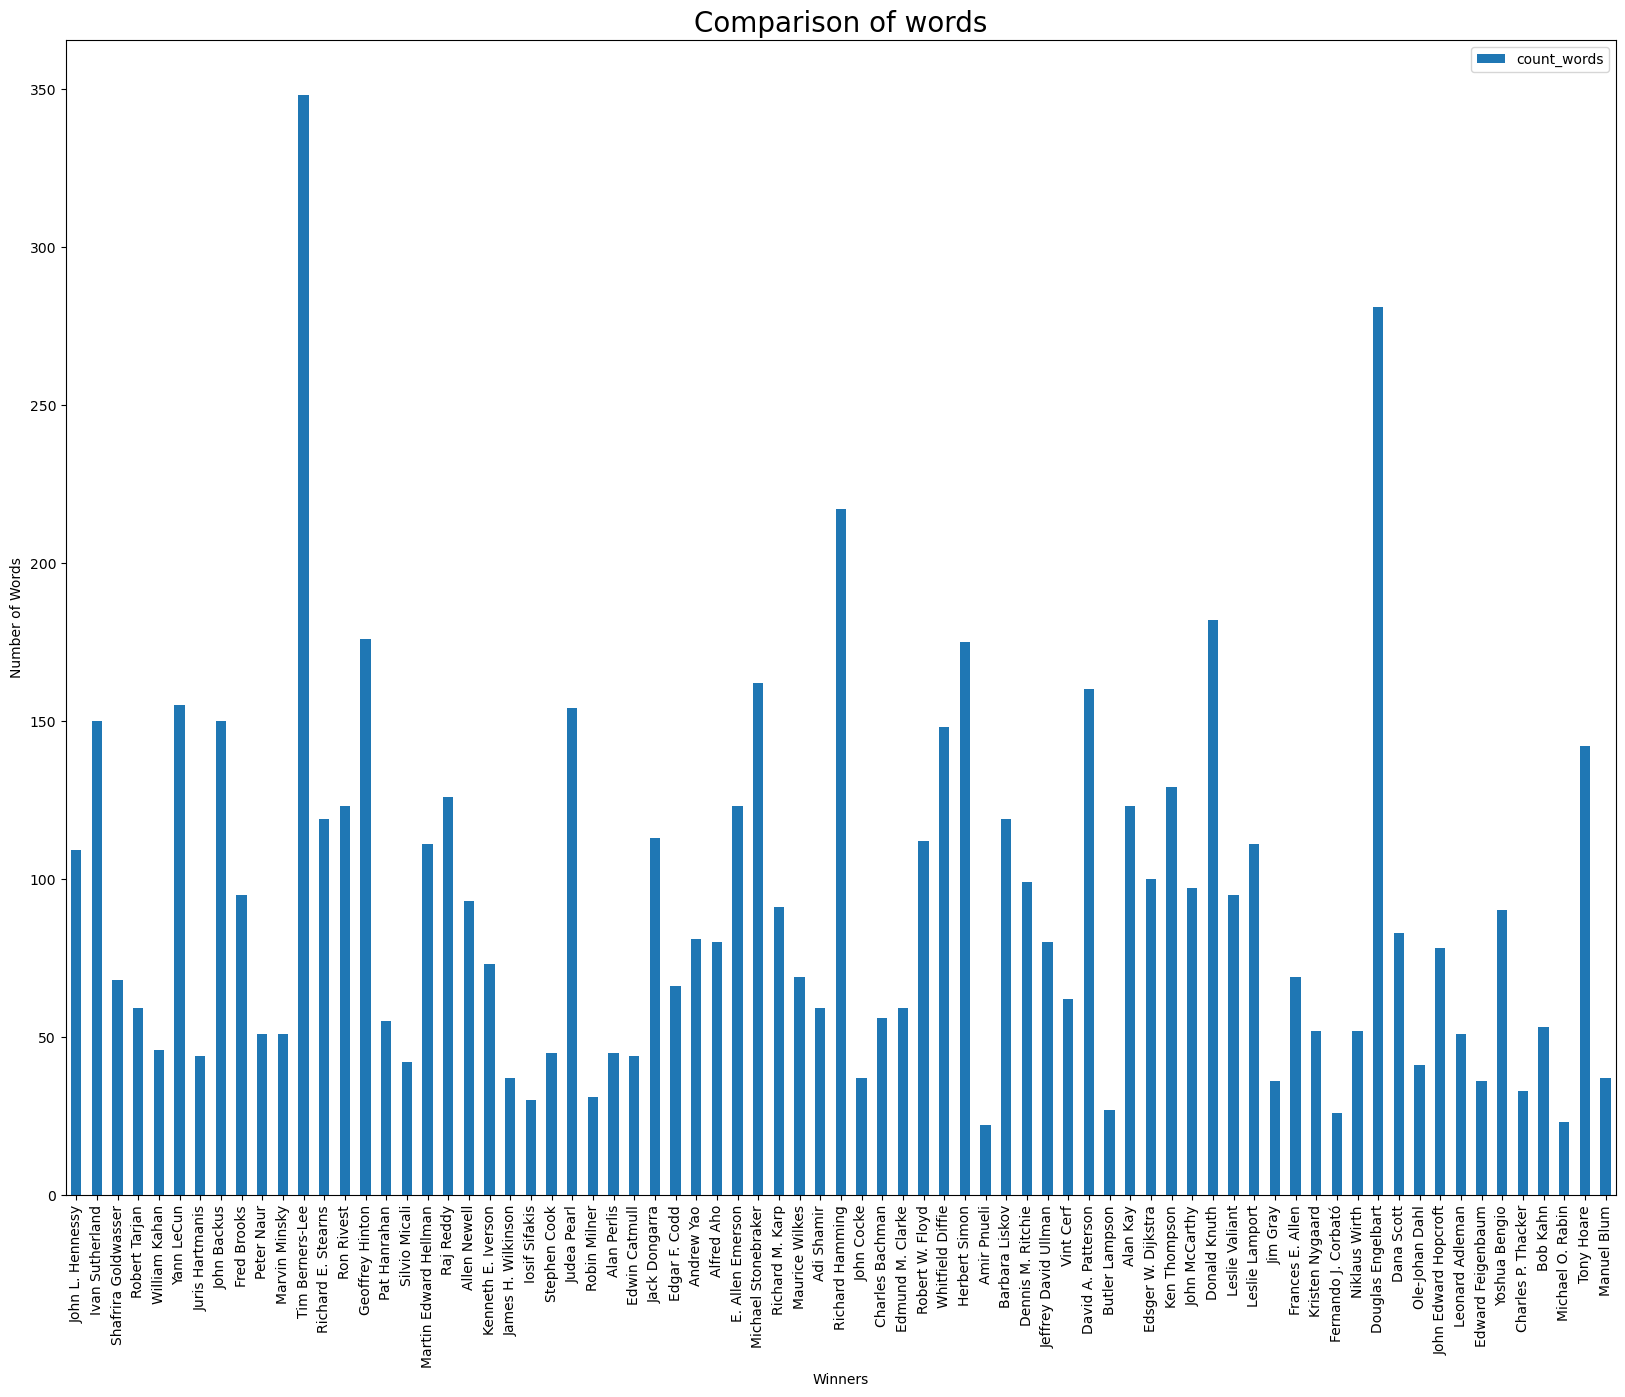

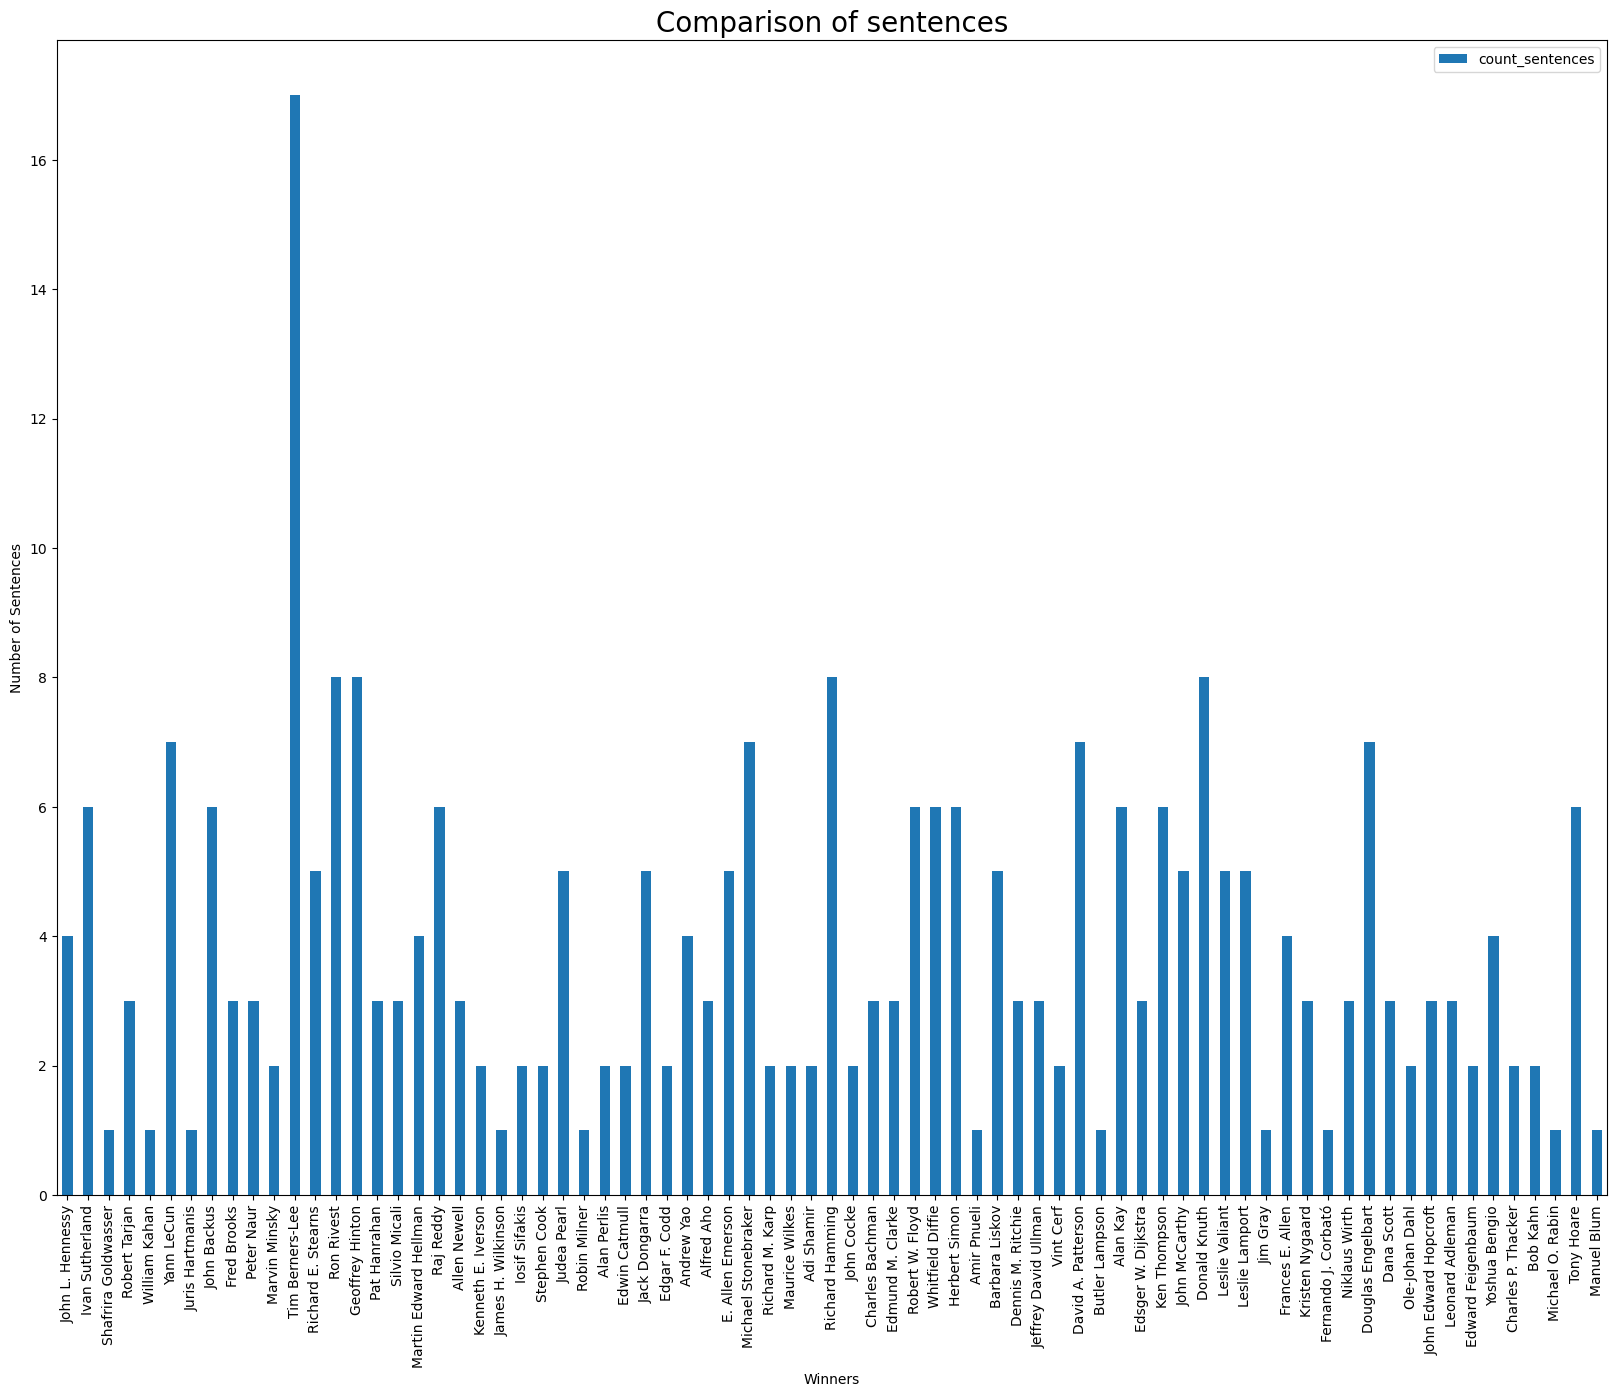

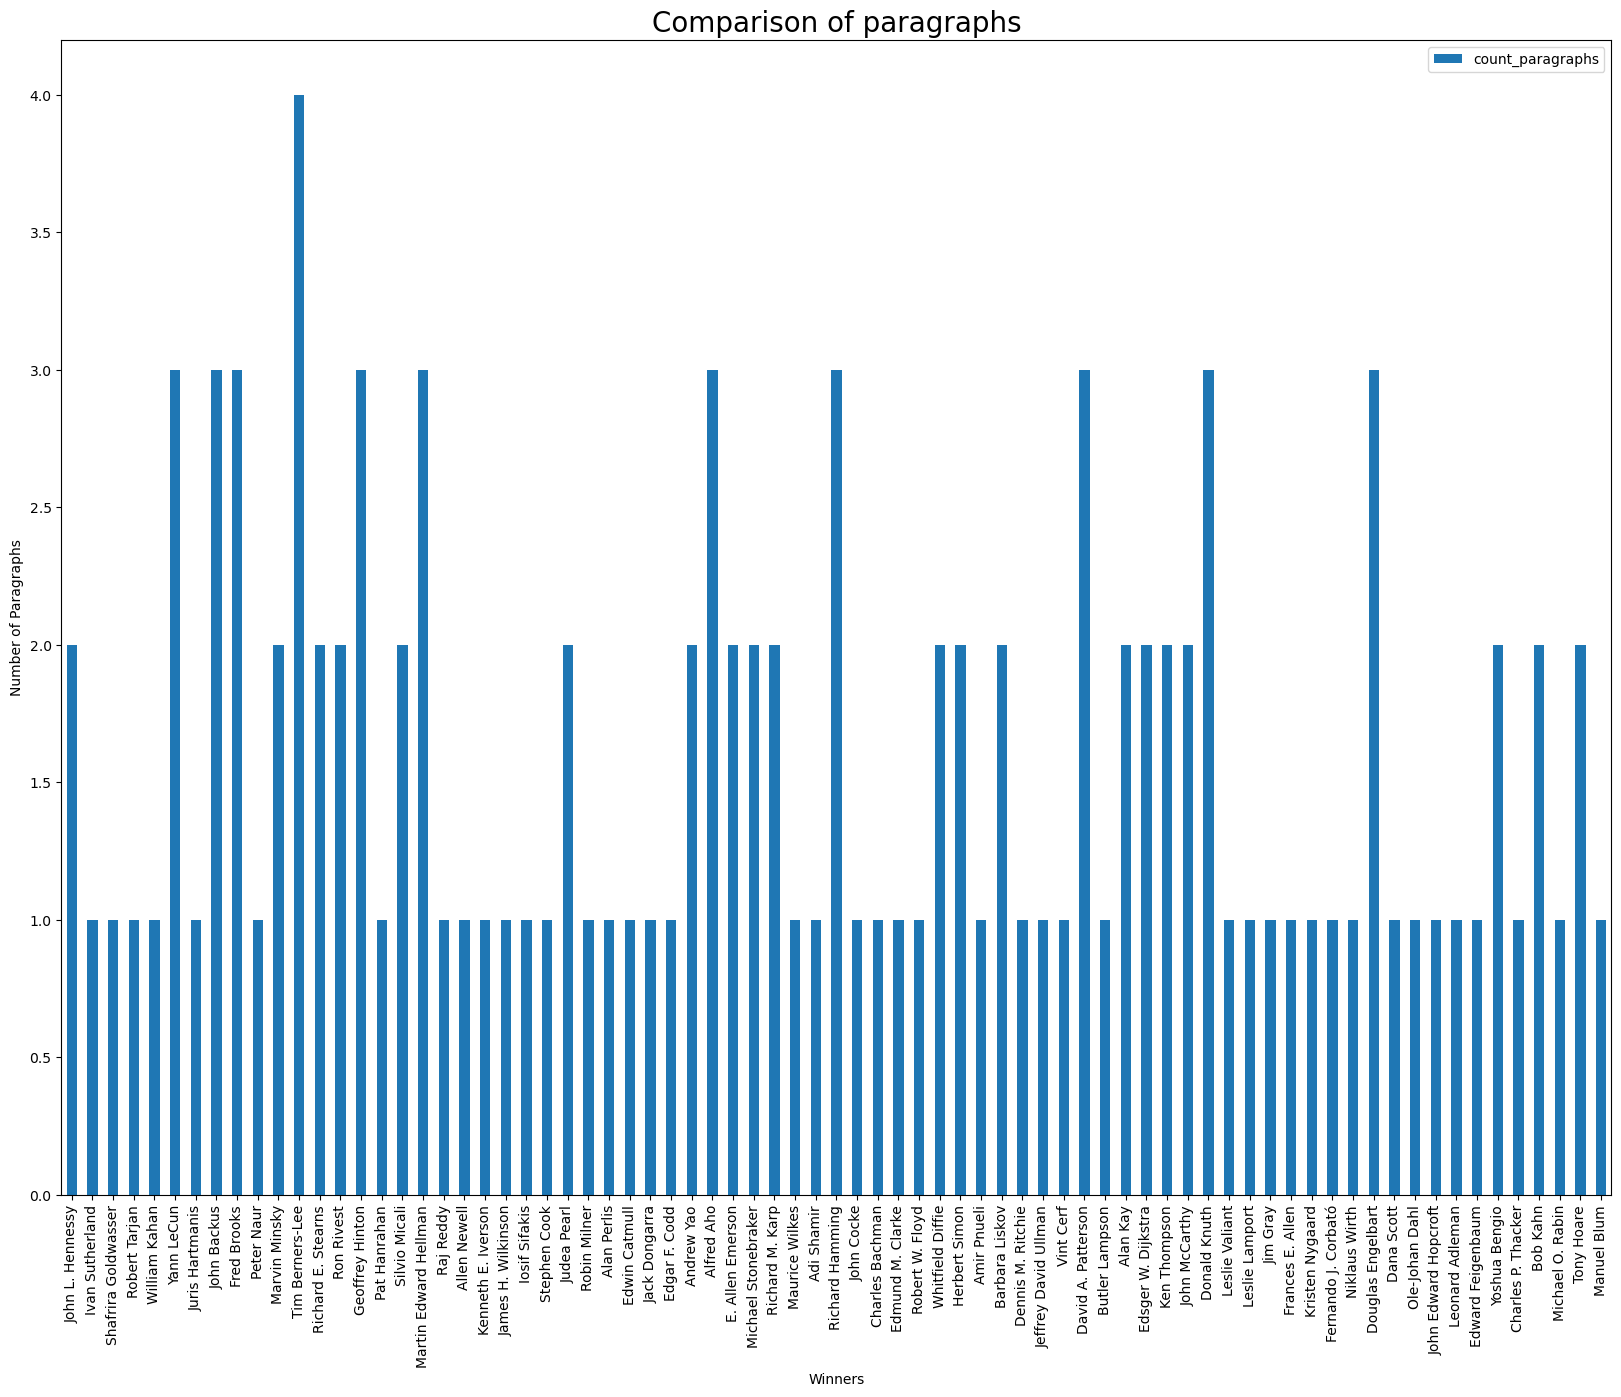

In [87]:
# Each plot is plotted using the award_winners_intro DataFrame in its own figure
# Plot the word counts for each winner's intro text
word_comparison = award_winners_intro.plot(x="winner_name", y="count_words", kind='bar', title ="Comparison of words", 
                                           figsize=(20, 15), legend=True)
word_comparison.set_xlabel("Winners")
word_comparison.set_ylabel("Number of Words")
plt.show()

# Plot the sentence counts for each winner's intro text
sentence_comparison = award_winners_intro.plot(x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentences", 
                                               figsize=(20, 15), legend=True)
sentence_comparison.set_xlabel("Winners")
sentence_comparison.set_ylabel("Number of Sentences")
plt.xticks(range(len(award_winners_intro["winner_name"])), award_winners_intro["winner_name"])
plt.show()

# Plot the paragraph counts for each winner's intro text
paragraph_comparison = award_winners_intro.plot(x="winner_name", y="count_paragraphs", kind='bar', title ="Comparison of paragraphs", 
                                                figsize=(20, 15), legend=True)
paragraph_comparison.set_xlabel("Winners")
paragraph_comparison.set_ylabel("Number of Paragraphs")
plt.xticks(range(len(award_winners_intro["winner_name"])), award_winners_intro["winner_name"])
plt.show()

<h4>Task 12</h4>

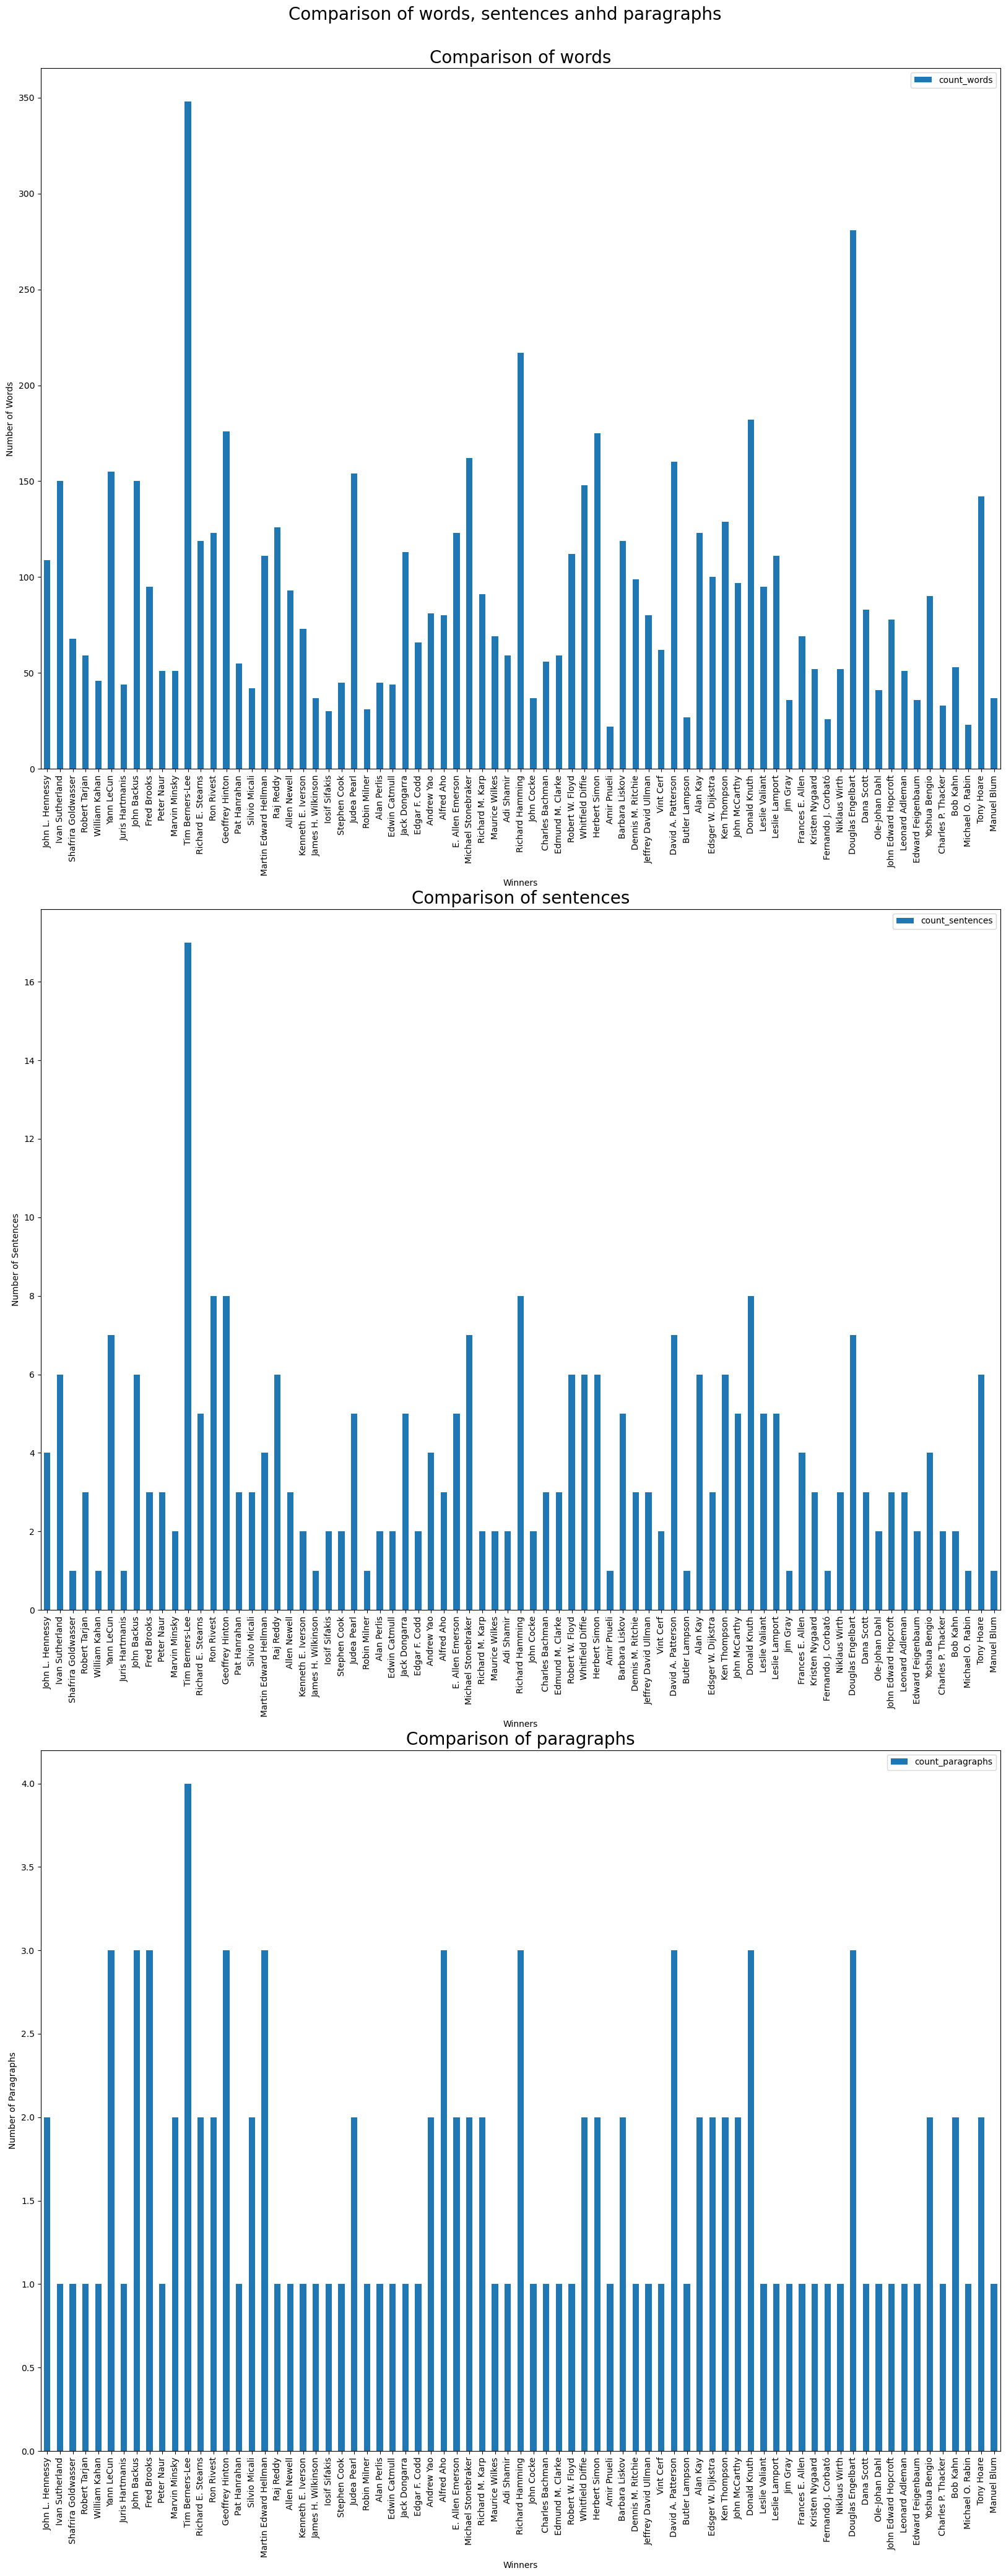

In [88]:
# Plot all three comparisons in one figure (3 by 1 subplots)
fig, axes = plt.subplots(3, figsize=(20, 50))
fig.suptitle("Comparison of words, sentences anhd paragraphs", x = 0.5, y = 0.90, fontsize = 20)

# Add plot of word counts for each winner's intro text
word_comparison = award_winners_intro.plot(ax = axes[0], x="winner_name", y="count_words", kind='bar', title ="Comparison of words", 
                                           legend=True)
word_comparison.set_xlabel("Winners")
word_comparison.set_ylabel("Number of Words")

# Add plot of sentence counts for each winner's intro text
sentence_comparison = award_winners_intro.plot(ax = axes[1], x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentences", 
                                               legend=True)
sentence_comparison.set_xlabel("Winners")
sentence_comparison.set_ylabel("Number of Sentences")

# Add plot of paragraph counts for each winner's intro text
paragraph_comparison = award_winners_intro.plot(ax = axes[2], x="winner_name", y="count_paragraphs", kind='bar', title ="Comparison of paragraphs", 
                                                legend=True)
paragraph_comparison.set_xlabel("Winners")
paragraph_comparison.set_ylabel("Number of Paragraphs")

plt.show()

<h4>Task 13</h4>

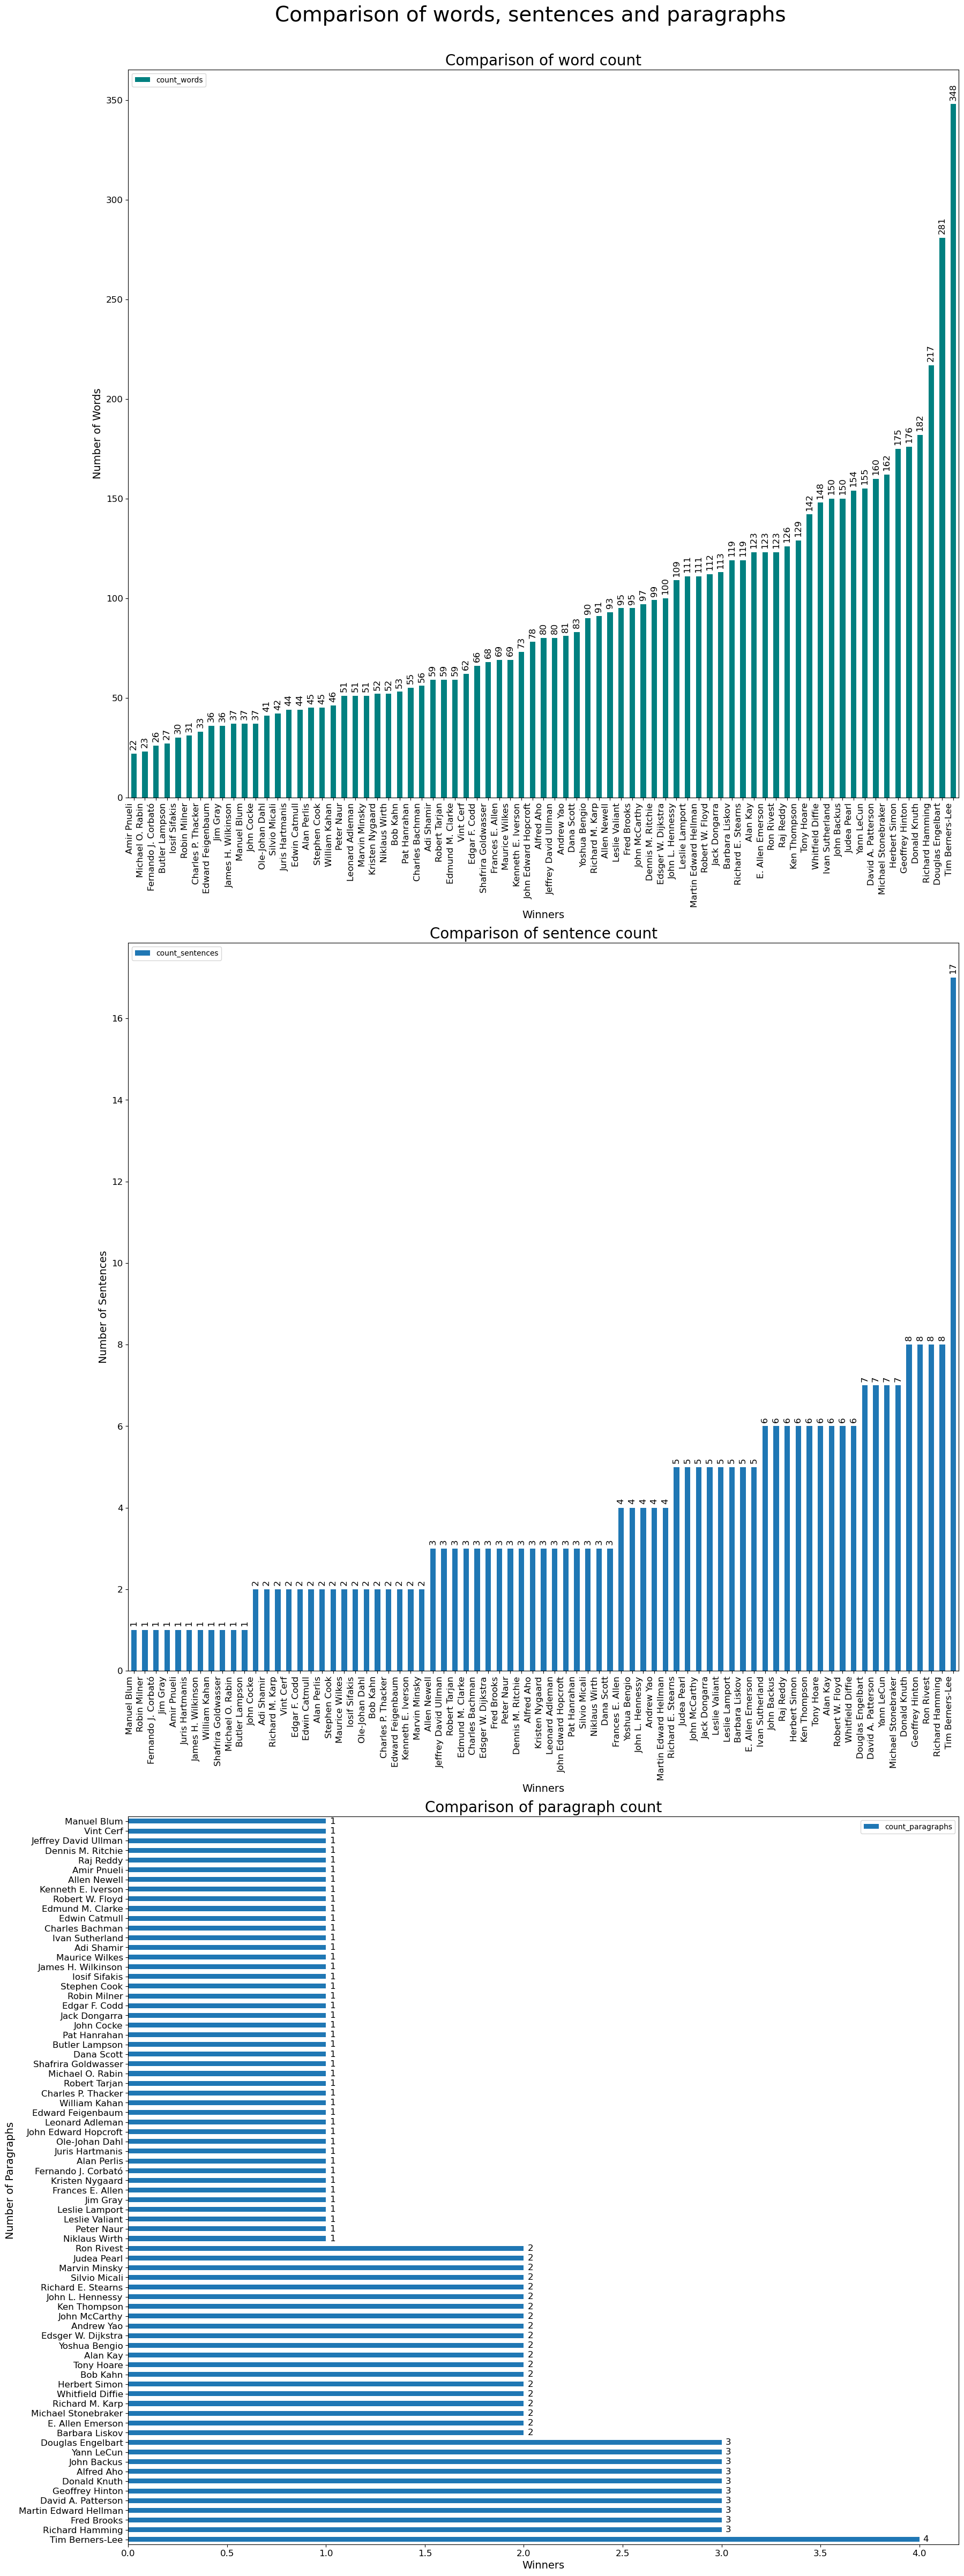

In [89]:
# Plot all three comparisons in one figure (3 by 1 subplots)
fig, axes = plt.subplots(3, figsize=(20, 60))
fig.suptitle("Comparison of words, sentences and paragraphs", x = 0.5, y = 0.90, fontsize = 28)
plt.rc('axes', titlesize = 20)
text_fontsize = 12
label_fontsize = 14

# Sort the award_winners_intro DataFrame by the number of words and sentences in ascending order; and paragraphs in descending order
sorted_word_counts = award_winners_intro.sort_values("count_words").reset_index(drop=True)
sorted_sentence_counts = award_winners_intro.sort_values("count_sentences").reset_index(drop=True)
sorted_paragraph_counts = award_winners_intro.sort_values("count_paragraphs", ascending=False).reset_index(drop=True)

# Add plot of word counts for each winner's intro text set color to teal and rotate the x-axis labels by 90 degrees
word_comparison = sorted_word_counts.plot(ax = axes[0], x="winner_name", y="count_words", kind='bar', title ="Comparison of word count", 
                                           legend=True, color="teal", fontsize=text_fontsize)                              
word_comparison.set_xlabel("Winners", fontsize=label_fontsize)
word_comparison.set_ylabel("Number of Words", fontsize=label_fontsize)
word_comparison.set_xticklabels(sorted_word_counts["winner_name"], rotation=90, ha='right')
word_comparison.bar_label(word_comparison.containers[0], rotation = 90, padding = 5, fontsize = text_fontsize)
word_comparison.legend(loc="upper left")

# Add plot of sentence counts for each winner's intro text and rotate the x-axis labels by 90 degrees
sentence_comparison = sorted_sentence_counts.plot(ax = axes[1], x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentence count", 
                                               legend=True, fontsize=text_fontsize)
sentence_comparison.set_xlabel("Winners", fontsize=label_fontsize)
sentence_comparison.set_ylabel("Number of Sentences", fontsize=label_fontsize)
sentence_comparison.set_xticklabels(sorted_sentence_counts["winner_name"], rotation=90, ha='right')
sentence_comparison.bar_label(sentence_comparison.containers[0], rotation = 90, padding = 5, fontsize = text_fontsize)
sentence_comparison.legend(loc="upper left")

# Add plot of paragraph counts for each winner's intro text and rotate the x-axis labels by 90 degrees. Plot the bars horizontally in descending order
paragraph_comparison = sorted_paragraph_counts.plot(ax = axes[2], x="winner_name", y="count_paragraphs", kind='barh', title ="Comparison of paragraph count", 
                                                legend=True, fontsize=text_fontsize)
paragraph_comparison.set_xlabel("Winners", fontsize=label_fontsize)
paragraph_comparison.set_ylabel("Number of Paragraphs", fontsize=label_fontsize)
paragraph_comparison.bar_label(paragraph_comparison.containers[0], padding = 5, fontsize = text_fontsize)

plt.show()

<h4>3.3.2 Heatmap</h4>

<h4>Task 14</h4>

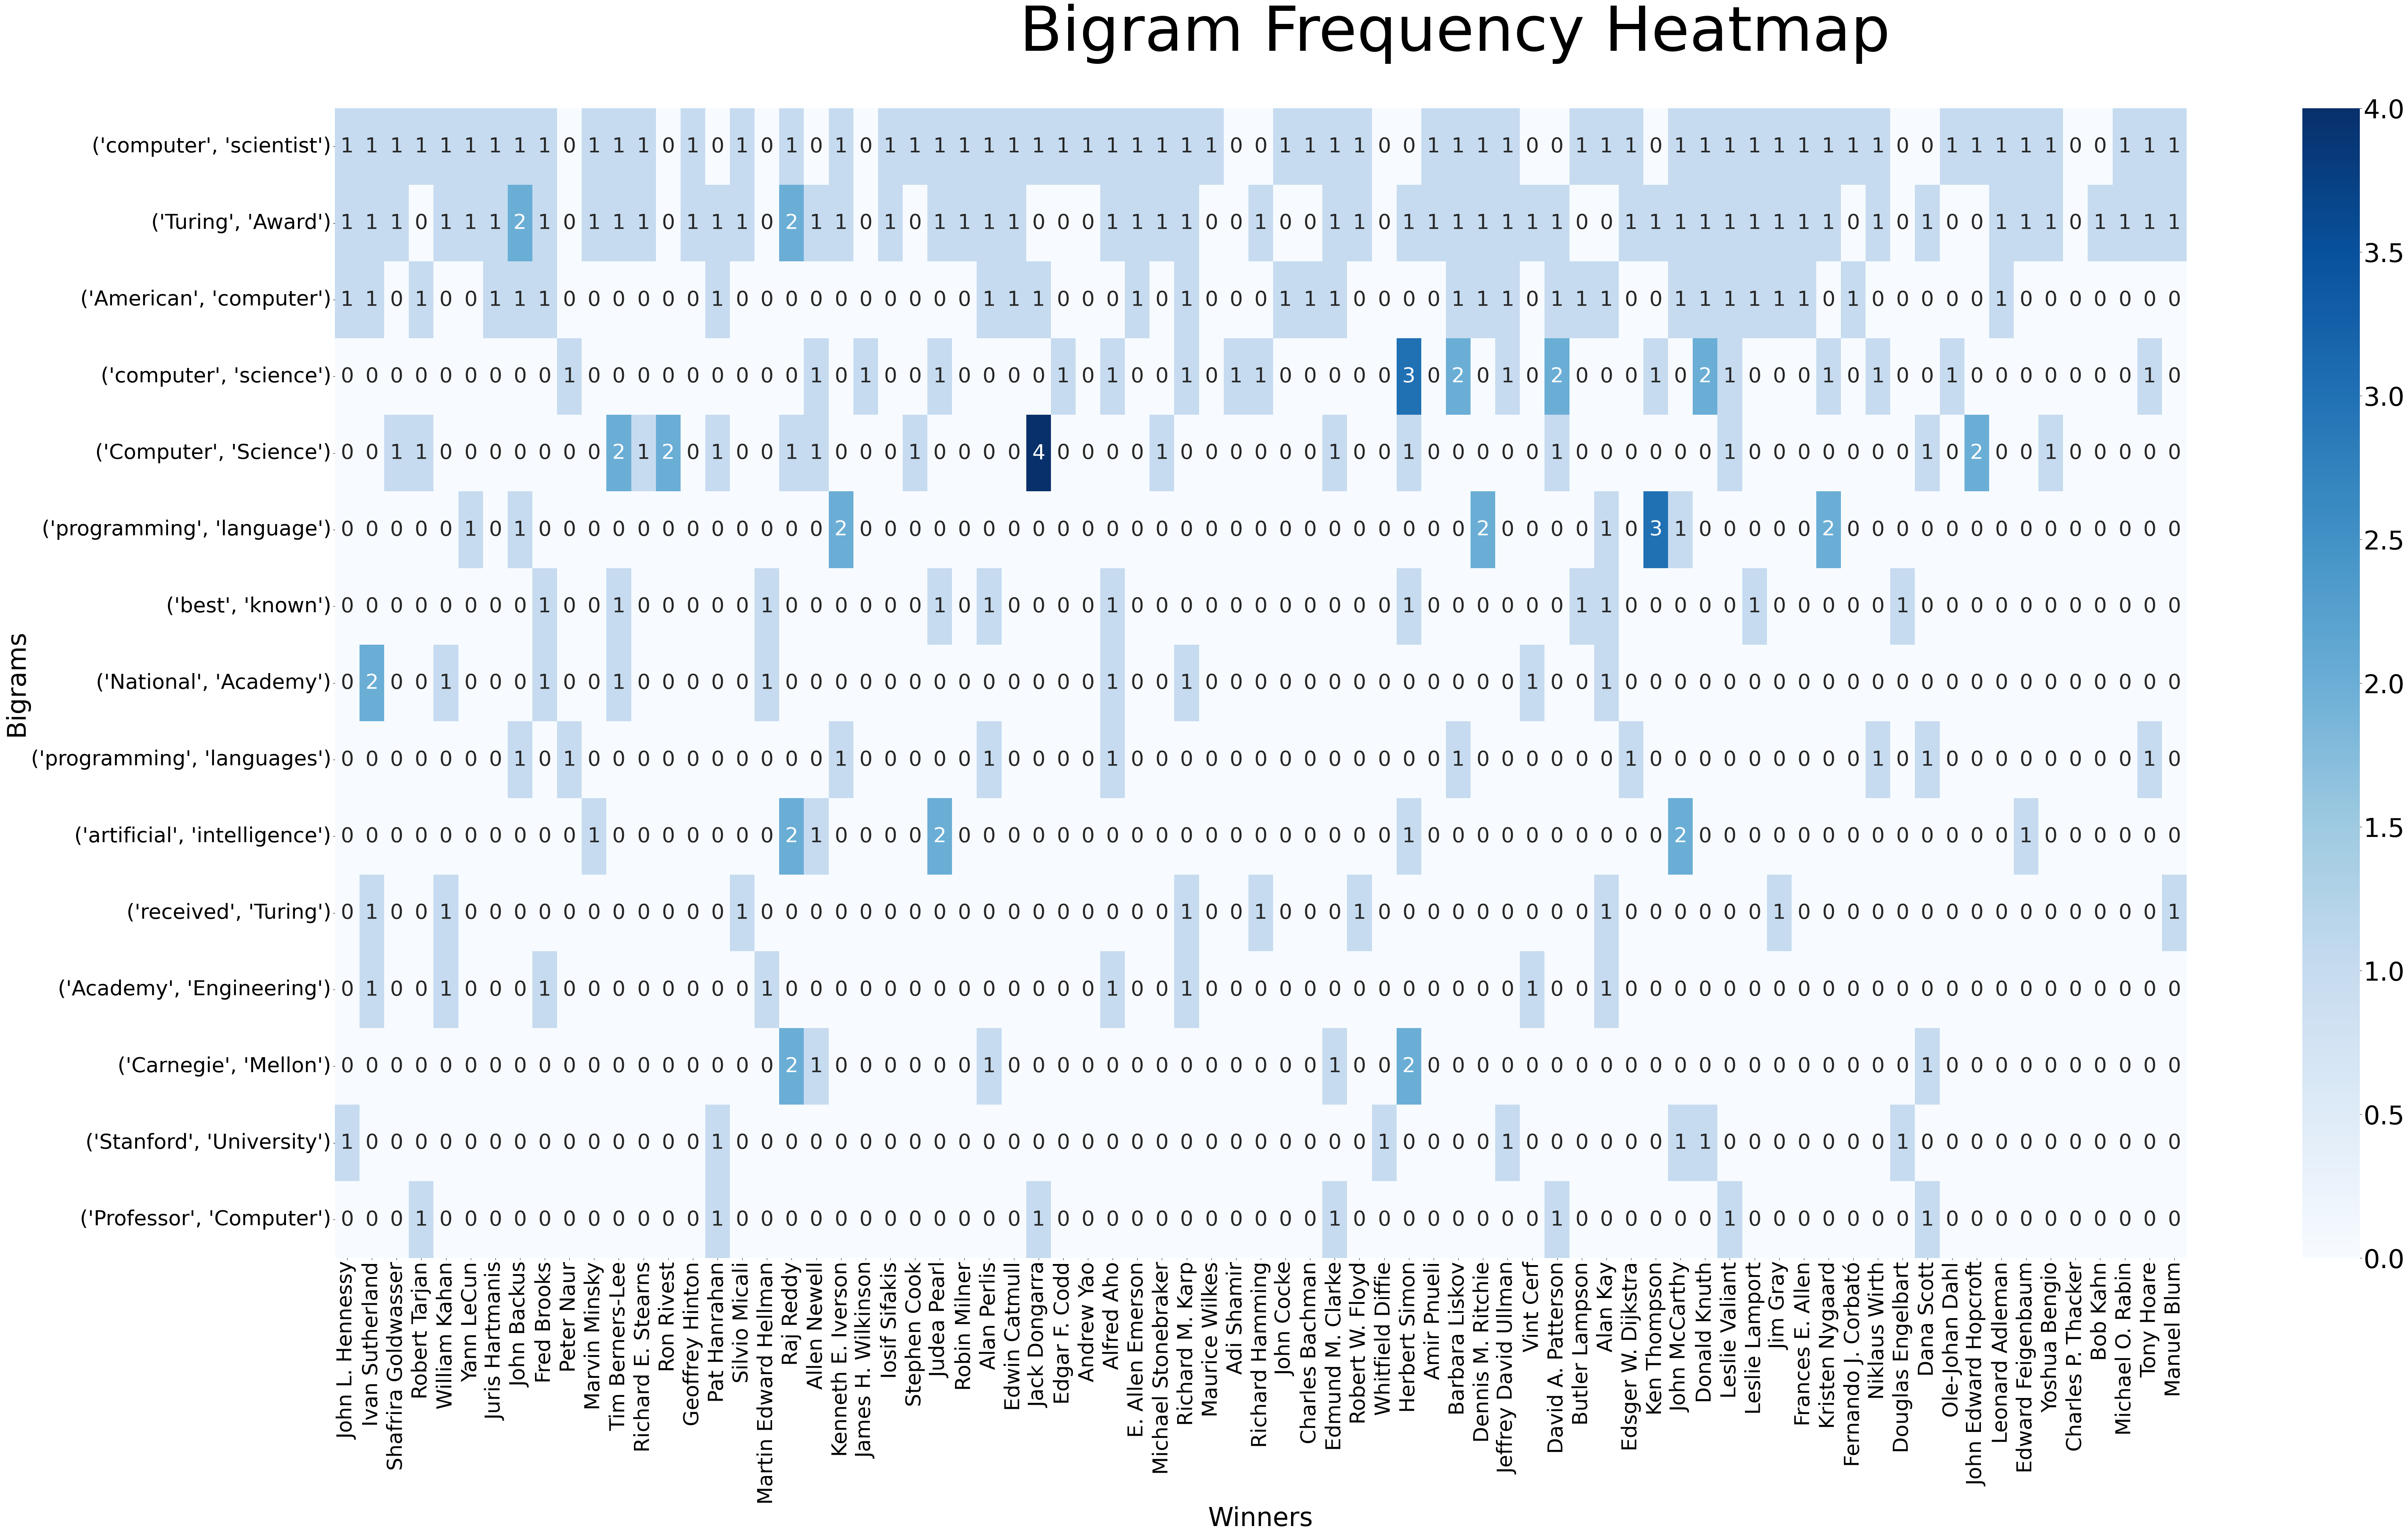

In [94]:
# Get the frequency of each bigram and return the top 15 bigrams
combined_intro_texts = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
combined_intro_words = process_intro_words(combined_intro_texts)
winners_bigrams = get_bigrams_frequency(combined_intro_words)

top15_bigrams = get_top_bigrams(winners_bigrams, 15)

# Process the intro text for each winner to extracts all bigrams in the intro text and store as a list of lists
intro_texts = [BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]]

# Create a list of dictionaries to store the frequency of each bigram for each winner
bigram_frequencies = []
for intro in intro_texts:
    intro_words = process_intro_words(intro)
    intro_bigrams = get_bigrams_frequency(intro_words)

    top15_intro_bigrams = {key: intro_bigrams[key] for key in top15_bigrams.keys() if key in intro_bigrams.keys()}

    bigram_frequencies.append(top15_intro_bigrams)

# Create a DataFrame to store the bigram frequencies for each winner. Extracts the bigram frequencies from the list of dictionaries
heatmap_df = pd.DataFrame(index = [key for key in top15_bigrams.keys()], columns = award_winners_intro["winner_name"]) 
for i,winner in enumerate(heatmap_df.columns):
    for bigram in bigram_frequencies[i].keys():
        heatmap_df[winner][bigram] = bigram_frequencies[i][bigram]

# Fill in the NaN values with 0 and plot the heatmap. Order of award winner names is dependent on the API call order
heatmap_df.fillna(0, inplace=True)

fig = plt.figure(figsize=(80,40))
fig.suptitle("Bigram Frequency Heatmap", x = 0.5, y = 0.95, fontsize = 120)
bigram_heatmap = sns.heatmap(heatmap_df, annot=True, cmap="Blues", annot_kws={"fontsize":40})
bigram_heatmap.tick_params(labelsize=40)
bigram_heatmap.set_yticklabels(heatmap_df.index, rotation=0)
bigram_heatmap.set_xlabel("Winners", fontsize=50)
bigram_heatmap.set_ylabel("Bigrams", fontsize=50)
bigram_heatmap.collections[0].colorbar.ax.tick_params(labelsize=50)
plt.show()